## Imports

In [1]:
import os
import jax
import numpyro
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import hssm
import arviz as az
import seaborn as sns

jax.config.update('jax_platform_name', 'cpu')
hssm.set_floatX("float32")
numpyro.set_host_device_count(14)

/Users/javierrojas/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [2]:
df_raw = pd.read_csv('data_wt_exp5.csv')

In [3]:
df_raw

,Unnamed: 0,participant,date,trial,angle,stim,stim_strength,incentive,desirability,valence,stake,endowment_size,resp,rt,correct,outcome,remain_endowment
0,0,1,2023-03-24_19h32.38.312,1,0.801364,0.8014,0.801364,1,-1.0,gain,0.5,0,1,1115.0,1,0.0,0.0
1,1,1,2023-03-24_19h32.38.312,2,-88.788249,-1.2118,1.211751,1,-1.0,gain,0.5,0,-1,2170.0,1,0.0,0.0
2,2,1,2023-03-24_19h32.38.312,3,-0.801364,-0.8014,0.801364,1,-1.0,gain,0.5,0,-1,2096.0,1,0.0,0.0
3,3,1,2023-03-24_19h32.38.312,4,-1.211751,-1.2118,1.211751,1,-1.0,gain,0.5,0,1,1687.0,0,0.0,0.0
4,4,1,2023-03-24_19h32.38.312,5,88.788249,1.2118,1.211751,1,-1.0,gain,0.5,0,-1,2857.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,19195,600,2023-03-27_18h03.18.908,28,88.788249,1.2118,1.211751,1,-1.0,loss,-0.5,16,1,2616.0,1,-0.5,9.5
19196,19196,600,2023-03-27_18h03.18.908,29,-89.198636,-0.8014,0.801364,1,-1.0,loss,-0.5,16,1,2698.0,0,-0.5,9.0
19197,19197,600,2023-03-27_18h03.18.908,30,0.801364,0.8014,0.801364,1,-1.0,loss,-0.5,16,-1,1673.0,0,-0.5,8.5
19198,19198,600,2023-03-27_18h03.18.908,31,1.211751,1.2118,1.211751,1,-1.0,loss,-0.5,16,-1,1415.0,0,-0.5,8.0


## Definitions

In [3]:
def subsitute_values_sequential(data,varname,new_values):
  unique_values = sorted(data[varname].unique())
  substitutions = {val: new_val for val, new_val in zip(unique_values,new_values)}
  return  data[varname].replace(substitutions)

In [4]:
def robust_z(x):
    x = np.asarray(x, float)
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 0.6745 * (x - med) / (mad if mad>0 else np.finfo(float).eps)

### Data Cleanup

In [5]:
data = df_raw.copy()

## stim side l/r (-1/1)
data['stim_side'] =  np.sign(data['stim'])

## Desirability side l/r (-1/1)
data['des_side'] = np.sign(data['stim'])*data['desirability']

## Stim evidence: low vs high (0/1)
data['stim_easy'] = subsitute_values_sequential(data,'stim_strength',[0.25,.5,0.75,1])

## Incentive: low vs high (0/1)
data['incentive'] = subsitute_values_sequential(data,'incentive',[-.5,.5])

## direction and magnitude
data['stim_des'] = data['stim_easy']*data['desirability'] 

data['resp_des'] = data['resp']*data['des_side'] #responded desirable vs undesirable (+1/-1)

data = data[data['desirability']!=0] #keep only trials with desirability manipulation (for now)
#%% Data cleaning/exclusion

MIN_RT = 200 
MAX_RT = 35000 
MAD_THRESH_RT = 3

ACC_THRESH_LO = 0.525 
ACC_THRESH_HI = 0.975

MIN_TRIALS_PER_COND = 8
COND_VARS = ['incentive', 'desirability']

#count original number of trials before exclusion
n_trials_raw= len(data)

In [6]:
data = data[(~data['correct'].isna()) & (~data['rt'].isna())
             & (data['rt']> MIN_RT) & (data['rt'] < MAX_RT) & (~data['resp'].isna())]

In [7]:
data = data[data.groupby('participant')['rt'].transform(lambda x: abs(robust_z(x)))<MAD_THRESH_RT]


In [8]:
print('N trials excluded = %i / %i'%(n_trials_raw - len(data),n_trials_raw))

print('Mean RT = %i ms, median RT = %i ms, max RT = %i ms' % (data['rt'].mean(),data['rt'].median(),data['rt'].max()))

N trials excluded = 1066 / 19200
Mean RT = 1734 ms, median RT = 1502 ms, max RT = 29557 ms


## Participant Cleanup

In [9]:
participant_accuracy = data.groupby('participant')['correct'].mean()
valid_participants = participant_accuracy[(participant_accuracy > ACC_THRESH_LO) & (participant_accuracy < ACC_THRESH_HI)].index

print('N participants kept (accuracy) = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

#remove participants with extreme median RTs compared to sample
participant_rt = data.groupby('participant')['rt'].median()
valid_participants_rt = participant_rt[np.abs(robust_z(participant_rt))<3].index
print('N participants kept (RT) = %i / %i'%(len(valid_participants_rt),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants_rt)]

# remove participants, who, after exclsion, have too few trials for one or more conditions
groupby_vars = ['participant']
groupby_vars.extend(COND_VARS)
sub_trials_per_cond = data.groupby(groupby_vars).size().reset_index(name='n_trials')

#get list of participants that have at least min_trials_per_cond trials per condition (combination of incentive and desirability values)
df_participants_with_min_trials = sub_trials_per_cond.groupby('participant').filter(lambda x: (x['n_trials'] >= MIN_TRIALS_PER_COND).all())
valid_participants = df_participants_with_min_trials['participant'].unique().tolist()
print('N participants kept after excluding participants with too few trials = %i / %i'%(len(valid_participants),len(data['participant'].unique())))
data = data[data['participant'].isin(valid_participants)]

N participants kept (accuracy) = 438 / 600
N participants kept (RT) = 427 / 438
N participants kept after excluding participants with too few trials = 425 / 427


## HSSM DataFrame

In [10]:
df_hssm = pd.DataFrame({
    'response': data['resp_des'].astype('int32'),
    'rt': (data['rt'] / 1000).astype('float32'),
    'participant_id': data['participant'].astype('int32')
})

df_hssm = df_hssm.astype({col: 'float32' for col in df_hssm.select_dtypes(include='float64').columns})

In [11]:
df_hssm

,response,rt,participant_id
0,-1,1.115,1
1,-1,2.170,1
2,-1,2.096,1
3,1,1.687,1
4,1,2.857,1
...,...,...,...
19195,-1,2.616,600
19196,1,2.698,600
19197,1,1.673,600
19198,1,1.415,600


In [12]:
random_ids = np.random.choice(
    df_hssm.participant_id.unique(),
    size=round(len(df_hssm.participant_id.unique())/10),
    replace = False
)

In [13]:
df_test = df_hssm[df_hssm['participant_id'].isin(random_ids)]

In [14]:
df_test

,response,rt,participant_id
2496,-1,3.7332,79
2497,1,2.9193,79
2498,-1,1.9682,79
2499,-1,2.2200,79
2500,1,3.0502,79
...,...,...,...
19131,-1,0.6140,598
19132,-1,1.2660,598
19133,-1,0.6180,598
19134,1,1.0000,598


## Fit model

In [18]:
all_summary = []

In [19]:
df_hssm

,response,rt,participant_id
2496,-1,3.7332,79
2497,1,2.9193,79
2498,-1,1.9682,79
2499,-1,2.2200,79
2500,1,3.0502,79
...,...,...,...
19131,-1,0.6140,598
19132,-1,1.2660,598
19133,-1,0.6180,598
19134,1,1.0000,598


In [20]:
for nsub, isub in enumerate(df_hssm['participant_id'].unique()):
    print(f"___Participant {isub}, {nsub+1}/{len(df_hssm['participant_id'].unique())}___")

    participant_folder = f"plots/Exp4/S{int(isub):04d}"   
    os.makedirs(participant_folder, exist_ok=True)

    df_hssm = df_test

    df_sub = df_hssm[df_hssm['participant_id'] == isub]
    df_sub.drop('participant_id', axis = 1, inplace=True)

    print("Median RT =", np.median(df_sub['rt']))
    print("N trials =", len(df_sub))

    model = hssm.HSSM(
        model="ddm",
        data=df_sub,
        include=[
            {
                "name":"a",
                "formula":"a ~ 1",
                "prior":{"Intercept":{"name":"Normal","mu":1.5,"sigma":0.5}}
            },
        ]
    )

    infer_data_sub = model.sample(
        cores=3,
        chains=3,
        draws=300,
        tune=1000,
        idata_kwargs=dict(log_likelihood=True),
        progressbar=True,
        target_accept=0.99,
    )

    fit_dict = infer_data_sub.to_dict()

    summary_table = az.summary(infer_data_sub).reset_index().rename(columns={'index':'param'})
    summary_table['participant_id'] = isub
    all_summary.append(summary_table)

/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 79, 1/42___
Median RT = 3.0202
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 96, 2/42___
Median RT = 1.7595
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 111, 3/42___
Median RT = 1.3351
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 176, 4/42___
Median RT = 2.5208
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 179, 5/42___
Median RT = 0.76535
N trials = 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 191, 6/42___
Median RT = 1.9412999
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 199, 7/42___
Median RT = 1.6433
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 202, 8/42___
Median RT = 2.0262
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 209, 9/42___
Median RT = 2.6404
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 221, 10/42___
Median RT = 2.08545
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 248, 11/42___
Median RT = 1.227
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 252, 12/42___
Median RT = 0.9885
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 276, 13/42___
Median RT = 1.0745
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 284, 14/42___
Median RT = 0.838
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 286, 15/42___
Median RT = 1.6471
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 308, 16/42___
Median RT = 1.9038
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 49 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 318, 17/42___
Median RT = 1.3918
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 321, 18/42___
Median RT = 1.5762
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 329, 19/42___
Median RT = 0.8885
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 333, 20/42___
Median RT = 2.4358
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 339, 21/42___
Median RT = 1.2688
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 48 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 357, 22/42___
Median RT = 1.9997
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 363, 23/42___
Median RT = 2.05975
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 374, 24/42___
Median RT = 1.50945
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 390, 25/42___
Median RT = 2.5336
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 391, 26/42___
Median RT = 1.343
N trials = 27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 394, 27/42___
Median RT = 1.47735
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 397, 28/42___
Median RT = 1.08925
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 68 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 403, 29/42___
Median RT = 1.1029
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 427, 30/42___
Median RT = 1.6157
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 445, 31/42___
Median RT = 1.6643
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 447, 32/42___
Median RT = 1.7258
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 68 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 470, 33/42___
Median RT = 1.315
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 47 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 485, 34/42___
Median RT = 1.1997
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 489, 35/42___
Median RT = 1.2648001
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 44 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 491, 36/42___
Median RT = 1.574
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 496, 37/42___
Median RT = 1.43735
N trials = 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 524, 38/42___
Median RT = 2.6875
N trials = 24


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 545, 39/42___
Median RT = 1.233
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 550, 40/42___
Median RT = 1.5561
N trials = 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 568, 41/42___
Median RT = 1.22745
N trials = 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/65/zt7m7_71489b2xgz9mqdpfl40000gn/T/ipykernel_45858/130263345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop('participant_id', axis = 1, inplace=True)
Only 300 samples in chain.


___Participant 598, 42/42___
Median RT = 1.219
N trials = 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [v, z, t, a_Intercept]


Sampling 3 chains for 1_000 tune and 300 draw iterations (3_000 + 900 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [21]:
df_all = pd.concat(all_summary, ignore_index=True)

In [22]:
df_all

,param,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,participant_id
0,v,0.241,0.209,-0.121,0.653,0.014,0.010,214.0,486.0,1.01,79
1,a_Intercept,1.366,0.122,1.136,1.585,0.007,0.005,309.0,349.0,1.00,79
2,z,0.435,0.083,0.300,0.599,0.006,0.005,179.0,400.0,1.02,79
3,t,1.428,0.169,1.105,1.700,0.014,0.010,168.0,361.0,1.02,79
4,v,-0.207,0.223,-0.626,0.183,0.016,0.011,194.0,315.0,1.01,96
...,...,...,...,...,...,...,...,...,...,...,...
163,t,0.560,0.052,0.460,0.635,0.003,0.002,321.0,236.0,1.01,568
164,v,-0.153,0.243,-0.613,0.287,0.013,0.009,339.0,504.0,1.01,598
165,a_Intercept,1.014,0.098,0.836,1.190,0.005,0.004,332.0,359.0,1.01,598
166,z,0.418,0.069,0.296,0.559,0.004,0.003,368.0,495.0,1.01,598


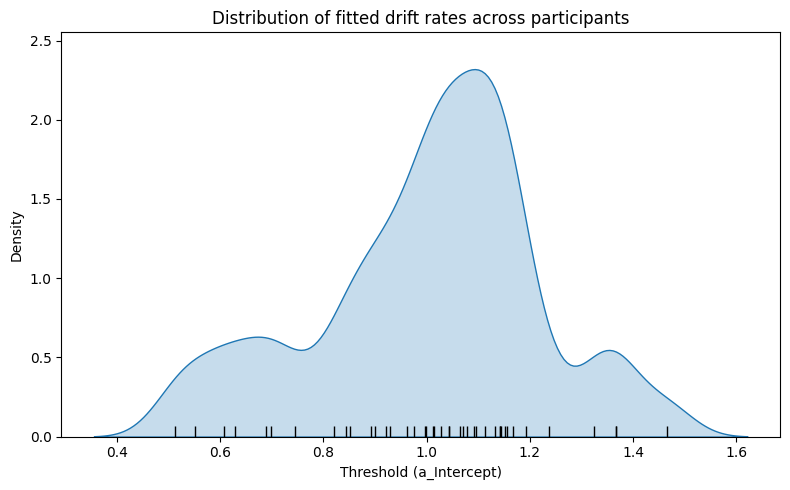

In [23]:
# Filter for drift rate (v_Intercept)
df_v = df_all[df_all['param'] == 'a_Intercept']

plt.figure(figsize=(8, 5))
sns.kdeplot(df_v['mean'], fill=True, bw_adjust=0.5)
sns.rugplot(df_v['mean'], color='k')
plt.xlabel("Threshold (a_Intercept)")
plt.ylabel("Density")
plt.title("Distribution of fitted drift rates across participants")
plt.tight_layout()
plt.show()


In [24]:
summary_table = az.summary(infer_data_sub)
print(summary_table.to_string())
with open(os.path.join(participant_folder, "summary_table_th.txt"), "w") as file:
    file.write(summary_table.to_string())

    # Save plots
az.plot_posterior(infer_data_sub)
plt.savefig(os.path.join(participant_folder, "posterior_plot_th.png"))
plt.close()

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
v           -0.153  0.243  -0.613    0.287      0.013    0.009     339.0     504.0   1.01
a_Intercept  1.014  0.098   0.836    1.190      0.005    0.004     332.0     359.0   1.01
z            0.418  0.069   0.296    0.559      0.004    0.003     368.0     495.0   1.01
t            0.476  0.060   0.364    0.572      0.004    0.003     289.0     225.0   1.02
